***Use different DataSet an perfrom Text Generation. Change 4 hyperparameters in the source and report findings***.

In [ ]:
#Importing required libraries
import tensorflow as tf
import numpy as np
import os
import time

Downloading the required text file from google website

In [ ]:
#Downloading the text file for processing
filename= 'origin_species.txt'
path = 'http://www.textfiles.com/etext/NONFICTION/origin_species'
Path_to_File = tf.keras.utils.get_file(filename, path)

Opening and reading the contents in the file and printing the number of characters in the file

In [ ]:
#Opening and reading data from the file
text = open(Path_to_File, 'rb').read().decode(encoding='utf-8')
No_of_Characters = len(text)
print ('Length of text i.e., Number of characters in the text file : {} characters'.format(No_of_Characters))

Length of text i.e., Number of characters in the text file : 1173621 characters


Printing first 250 characters from the text file

In [ ]:
#Printing first 250 characters in the text file
print(text[:250])

                                      1859
                             THE ORIGIN OF SPECIES
                               by Charles Darwin
                                      1859
INTRODUCTION
  INTRODUCTION

  WHEN on board H.M.S. Beagle as na


Printing whole content in the file

In [ ]:
print(text)


                                      1859
                             THE ORIGIN OF SPECIES
                               by Charles Darwin
                                      1859
INTRODUCTION
  INTRODUCTION

  WHEN on board H.M.S. Beagle as naturalist, I was much struck with
certain facts in the distribution of the organic beings inhabiting
South America, and in the geological relations of the present to the
past inhabitants of that continent. These facts, as will be seen in
the latter chapters of this volume, seemed to throw some light on
the origin of species- that mystery of mysteries, as it has been
called by one of our greatest philosophers. On my return home, it
occurred to me, in 1837, that something might perhaps be made out on
this question by patiently accumulating and reflecting on all sorts of
facts which could possibly have any bearing on it. After five years'
work I allowed myself to speculate on the subject, and drew up some
short notes; these I enlarged in 1844 i

Extracting and counting unique characters from the text file

In [ ]:
#Extracting and counting unique characters from the text file
unique_characters = sorted(set(text))
print ('{} unique characters'.format(len(unique_characters)))
print(unique_characters)

77 unique characters
['\n', ' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


**Processing the text**

***Vectorization of the text:*** Before training of the model,firstly there is need of mapping strings to numerical representations. We create 2 lookup tables for

1) Mapping numbers to characters

2)Mapping characters to numbers

In [ ]:
#Mapping strings to numerical representations
char2idx = {u:i for i, u in enumerate(unique_characters)}
idx2char = np.array(unique_characters)
text_as_int = np.array([char2idx[c] for c in text])
print(char2idx)


{'\n': 0, ' ': 1, '!': 2, '"': 3, '&': 4, "'": 5, '(': 6, ')': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '?': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'E': 29, 'F': 30, 'G': 31, 'H': 32, 'I': 33, 'J': 34, 'K': 35, 'L': 36, 'M': 37, 'N': 38, 'O': 39, 'P': 40, 'Q': 41, 'R': 42, 'S': 43, 'T': 44, 'U': 45, 'V': 46, 'W': 47, 'X': 48, 'Y': 49, 'Z': 50, 'a': 51, 'b': 52, 'c': 53, 'd': 54, 'e': 55, 'f': 56, 'g': 57, 'h': 58, 'i': 59, 'j': 60, 'k': 61, 'l': 62, 'm': 63, 'n': 64, 'o': 65, 'p': 66, 'q': 67, 'r': 68, 's': 69, 't': 70, 'u': 71, 'v': 72, 'w': 73, 'x': 74, 'y': 75, 'z': 76}


**Create training targets and examples.**

Break up the text into example sequences. The text will be seq_length characters in each input sequence.


The corresponding targets for each input sequence include the same length of text, but shifted one character to the right.


As a result, divide the text into (seq_length+1) parts. Consider the case where seq_length is 4 and our text is "Hello." "Hell" would be the input sequence, while "ello" would be the destination sequence.


To begin, turn the text vector into a stream of character indices using the tf.data.Dataset.from_tensor_slices function.

In [ ]:
#The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)
# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)


Used ***batch()*** method to convert the individual characters formed into a sequence of desired size

In [ ]:
#Converting the single characters to sequence of desired size
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'                                      1859\n                             THE ORIGIN OF SPECIES\n       '
'                        by Charles Darwin\n                                      1859\nINTRODUCTION\n  I'
'NTRODUCTION\n\n  WHEN on board H.M.S. Beagle as naturalist, I was much struck with\ncertain facts in the'
' distribution of the organic beings inhabiting\nSouth America, and in the geological relations of the '
'present to the\npast inhabitants of that continent. These facts, as will be seen in\nthe latter chapter'


For each sequence, duplicate and shift it to form the input and target text by using the map method to apply a simple function to each batch

In [ ]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

Printing the first examples input and target values:

In [ ]:
#Printing the first examples input and target values
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  '                                      1859\n                             THE ORIGIN OF SPECIES\n      '
Target data: '                                     1859\n                             THE ORIGIN OF SPECIES\n       '


***The Prediction Loop***

The following code block generates the text which we need as our final output

It begins by selecting a start string, configuring the RNN state, and determining the amount of characters to be generated.


Using the start string and the RNN state, calculate the following character's prediction distribution.


Then, using a categorical distribution, determine the projected character's index. Use this anticipated character as the model's next input.


The RNN state returned by the model is given back into the model, giving it more context than it had previously. The changed RNN states are input back into the model after predicting the next character, which is how it learns as it gains more context from the previously anticipated characters.

In [ ]:
#User Defined function to generate the text as output
def generate_text(model, start_string):
  num_generate = 1000
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  temperature = 1.0
  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

***Create training batches***:

We used tf.data to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [ ]:
#Creating training batches for the data
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

Specifying the embedding dimensions and number of units in RNN

In [ ]:
vocab_size = len(unique_characters)
embedding_dim = 256
rnn_units = 1024

***Build The Model(Model 1):***

Use tf.keras.Sequential to define the model. Here we used three layers are used to define our model:

**tf.keras.layers.Embedding:** The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;

**tf.keras.layers.GRU:** A type of RNN with size units=rnn_units

**tf.keras.layers.Dense:** The output layer, with vocab_size outputs.

In [ ]:
#Building the Model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  Keras_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return Keras_model

In [ ]:
Keras_model = build_model(
    vocab_size = len(unique_characters),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

Checking the shape of our model

In [ ]:
#Checking the shape of our model
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = Keras_model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 77) # (batch_size, sequence_length, vocab_size)


In [ ]:
Keras_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (64, None, 256)           19712     
                                                                 
 gru_2 (GRU)                 (64, None, 1024)          3938304   
                                                                 
 dense_8 (Dense)             (64, None, 77)            78925     
                                                                 
Total params: 4,036,941
Trainable params: 4,036,941
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [ ]:
#Trying it for first example in the batch
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([62, 63, 13,  3, 37, 52, 19, 35, 63,  0, 60, 70, 44,  8, 30, 24, 40,
       23,  1,  0, 32, 75, 14, 60,  6, 16, 67,  2, 36, 62, 11,  0, 36, 48,
       38, 43, 37, 67, 67, 11, 47,  8, 36, 41, 28, 56, 34, 23, 22,  8, 52,
       68,  7, 64, 36, 73, 70, 47, 40, 27, 66, 75,  5, 32, 58, 31, 30, 41,
       34, 37, 40, 72, 65, 19,  0, 42, 30,  2, 10,  3,  8, 24, 72, 68, 30,
       20, 45, 16, 13, 65,  5, 61, 12, 42, 15, 27, 25, 15, 61, 20])

In [ ]:
#Defining loss function to use it in the further steps
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 77)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.3448296


Configure the training procedure using the tf.keras.Model.compile method. We'll use tf.keras.optimizers.Adam with default arguments and the loss function.

In [ ]:
#Compiling the model
Keras_model.compile(optimizer='adam', loss=loss)

***Configure checkpoints***

Use a tf.keras.callbacks.ModelCheckpoint to ensure that checkpoints are saved during training

In [ ]:
#Configuring the checkpoints
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
#Fitting the model to the data with loss function specification
EPOCHS=10
history = Keras_model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
181/181 [==============================] - 13s 52ms/step - loss: 2.5702
Epoch 2/10
181/181 [==============================] - 11s 53ms/step - loss: 1.7410
Epoch 3/10
181/181 [==============================] - 11s 53ms/step - loss: 1.4069
Epoch 4/10
181/181 [==============================] - 11s 53ms/step - loss: 1.2650
Epoch 5/10
181/181 [==============================] - 11s 53ms/step - loss: 1.1866
Epoch 6/10
181/181 [==============================] - 11s 53ms/step - loss: 1.1321
Epoch 7/10
181/181 [==============================] - 11s 53ms/step - loss: 1.0900
Epoch 8/10
181/181 [==============================] - 11s 54ms/step - loss: 1.0533
Epoch 9/10
181/181 [==============================] - 11s 54ms/step - loss: 1.0207
Epoch 10/10
181/181 [==============================] - 11s 54ms/step - loss: 0.9919


Restore the latest checkpoint To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different batch_size, we need to rebuild the model and restore the weights from the checkpoint.



In [ ]:
#Restoring the latest checkpoint
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (1, None, 256)            19712     
                                                                 
 gru_3 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_9 (Dense)             (1, None, 77)             78925     
                                                                 
Total params: 4,036,941
Trainable params: 4,036,941
Non-trainable params: 0
_________________________________________________________________


Generating text by applying the model by giving a sample phrase

In [ ]:
print(generate_text(model, start_string=u"Although "))

Although in colour and old body either had
hatched, and
in a breed. Tint is notorious that each group from different varies
being one varyis
have had the plants which, for instance,

  Oline and being thus carefully for one and auth, of which nevertheless with the present day depend on what another dividibed
has not to be indefin the forms were much reduced or as if Noood. A compared immenter
variety. For
in
the two classes
after and collect flowers of the Causes of the skull is composed of all organic
beings
quifest- escantageous Turks, with some small parent
specimens
were
respected. The excrement of
cy
blended together much less than to
antwer, and North America special difficulty of the species over a
great majority would flower to have been the form; but the plants or Mr. Havanded essent and body in certainly displayed in other birds. So again in making known in the newly-five, but let us almost
a word, and bees are our
bees, which is
to be inferred from a single
lifetion in some 

In [ ]:
#Example 2
print(generate_text(model, start_string=u"Some"))

Some limbs and then,
bringing the world Gach agency throughout this geographical habition of the opposite sixty of nature it somewhere litter. They are as enabled to, nevertheless on
the blue spot, with the body shown, quite about o50 peassia, correlated into another
differences in their illaps and to the pred
means, it is that the breed has given by graduated females of the earth, and
its mereaffects suddenly, and the great nudrents from degrooditis might
have been reconverted by their cells so say. Let me theory of
record.
  There could never be easy to differ from each other than in the Glacial members of seeds open of down with man.   There is reason to
suppose that the form of an old home, but disappear favoured it might either look at creation, I can affect the Galapagos Asist cross is, that
"The greater number of each former
plants and lamina they are supposed some loous birds, after long and
naturalists would have been sumple given in anomaly in nutriment.
  On these Edlands, a

***Model 2(Hyperparameter 1):***

As there is more loss observed in the previous model and the model failed to generate the meaningful text, created model 2

Here replaced GRU layer with **LSTM** layer with activation function "tanh" because LSTM will work accurately  with longer sequences than GRU

In [ ]:
#Building the model 2 by replacing GRU layer with LSTM layer (hyperparameter 1)
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  Keras_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                          return_sequences=True,
                          activation='tanh',
                          recurrent_activation='sigmoid',
                          stateful=True,
                          recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return Keras_model

In [ ]:
Keras_model = build_model(
    vocab_size = len(unique_characters),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [ ]:
Keras_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (64, None, 256)           19712     
                                                                 
 lstm_6 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 dense_10 (Dense)            (64, None, 77)            78925     
                                                                 
Total params: 5,345,613
Trainable params: 5,345,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compiling Model 2
Keras_model.compile(optimizer='adam', loss=loss)

In [ ]:
#Fitting the model 2 to the data
EPOCHS=10
history = Keras_model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
181/181 [==============================] - 15s 66ms/step - loss: 2.4440
Epoch 2/10
181/181 [==============================] - 13s 66ms/step - loss: 1.6328
Epoch 3/10
181/181 [==============================] - 13s 66ms/step - loss: 1.3527
Epoch 4/10
181/181 [==============================] - 13s 67ms/step - loss: 1.2368
Epoch 5/10
181/181 [==============================] - 14s 67ms/step - loss: 1.1681
Epoch 6/10
181/181 [==============================] - 13s 67ms/step - loss: 1.1193
Epoch 7/10
181/181 [==============================] - 14s 67ms/step - loss: 1.0780
Epoch 8/10
181/181 [==============================] - 14s 67ms/step - loss: 1.0426
Epoch 9/10
181/181 [==============================] - 14s 67ms/step - loss: 1.0089
Epoch 10/10
181/181 [==============================] - 14s 68ms/step - loss: 0.9732


In [ ]:
#Restoring latest checkpoint
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (1, None, 256)            19712     
                                                                 
 lstm_7 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_11 (Dense)            (1, None, 77)             78925     
                                                                 
Total params: 5,345,613
Trainable params: 5,345,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Example 1
print(generate_text(model, start_string=u"Some"))

Some
what wings no doubt the most advanced of that large areas, if it had
undergone some other sides, slow trees, and the power of
seiz shell is common to the rock-pigeon in the
same regions? Hingerm numerous one species, with the very species
being unland on the same part, the
conditions of life is much teographical changes which remain for climbing cross,
a few centingents or regions at the means, at which ves in these
fertility- that it in shies or cutting how they have sudden
rudimentary. Nor looks any regularfunities of organisations. Space doons to  seems to me to great that of the
species in the same are should after to each other
than it has been mucerrany with our changes inhabiting the electric Australian embeds. It must apply to kee them, however, even the southern hemispheres of
question. Without the female analogous nasting cannot
propagated seas: he will be different from an equally stated
by certain seasons of any other case higher than
the nature of the ordinary shores 

***Model 3(Hyperparameter 2):***
We can see that loss is increased and there is still overfitting issue, added a Dropout layer with 0.3 input size to reduce overfitting of the data and for accurate text generation


In [ ]:
#Building Model3 by adding a DropOut layer(HyperParameter)
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  Keras_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                          return_sequences=True,
                          activation='tanh',
                          recurrent_activation='sigmoid',
                          stateful=True,
                          recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(vocab_size)
  ])
  return Keras_model

In [ ]:
Keras_model = build_model(
    vocab_size = len(unique_characters),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [ ]:
Keras_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (64, None, 256)           19712     
                                                                 
 lstm_8 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 dropout_4 (Dropout)         (64, None, 1024)          0         
                                                                 
 dense_12 (Dense)            (64, None, 77)            78925     
                                                                 
Total params: 5,345,613
Trainable params: 5,345,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compiling the Model
Keras_model.compile(optimizer='adam', loss=loss)

In [ ]:
#Fitting the Model to the data
EPOCHS=10
history = Keras_model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
181/181 [==============================] - 15s 69ms/step - loss: 2.5021
Epoch 2/10
181/181 [==============================] - 14s 68ms/step - loss: 1.7153
Epoch 3/10
181/181 [==============================] - 14s 68ms/step - loss: 1.4306
Epoch 4/10
181/181 [==============================] - 14s 68ms/step - loss: 1.3086
Epoch 5/10
181/181 [==============================] - 14s 68ms/step - loss: 1.2367
Epoch 6/10
181/181 [==============================] - 14s 68ms/step - loss: 1.1871
Epoch 7/10
181/181 [==============================] - 14s 69ms/step - loss: 1.1482
Epoch 8/10
181/181 [==============================] - 14s 69ms/step - loss: 1.1155
Epoch 9/10
181/181 [==============================] - 14s 69ms/step - loss: 1.0867
Epoch 10/10
181/181 [==============================] - 14s 69ms/step - loss: 1.0610


In [ ]:
#Restoring the latest checkpoint
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (1, None, 256)            19712     
                                                                 
 lstm_9 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dropout_5 (Dropout)         (1, None, 1024)           0         
                                                                 
 dense_13 (Dense)            (1, None, 77)             78925     
                                                                 
Total params: 5,345,613
Trainable params: 5,345,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Text generation using the model
print(generate_text(model, start_string=u"Some"))

Some more universally
resemblance to such naturelating for imagn a present
dark as extend important much than tend to have been coloured; but not that in the incessorr benefice to the animal what important from the measures of any one being now different that each
has been astly becomes
Never fishes almost examples of others, made not breeding by man tills; and prey leadn POROLOGICALA, ON the higher generally pervods in a more pabiliar and puscle, which I will generally appear to be very bringing variations of
small contfress of the
homes, and are in some natrividy pigaed probably at habits and rarely various inferences of a state of dearth, whilst one
the same species or by the individuals of the same genus; and the cells of creation. A wide range of general place
in fornicing the
fectuc long tion more
interesting is quite different in convincent generalong they offer an exal, be part or more transported with birds and movement of thEse groups of facility, as we shall have by a whole 

***Model 4(Hyperparameter 3):***


Changing sizes of embedding dimensions and number of RNN units as our hyperparameter 3.

Increased the embedding dimension so that the output dimension of the first layer will be large enough for better computation speed and results.

Increased the units in the RNN layer so that there will be more neurons which will help increase the accuracy.

In [ ]:
vocab_size = len(unique_characters)
embedding_dim = 512     
rnn_units = 2048        

In [ ]:
#defining the Model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  Keras_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                          return_sequences=True,
                          activation='tanh',
                          recurrent_activation='sigmoid',
                          stateful=True,
                          recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(vocab_size)
  ])
  return Keras_model

In [ ]:
Keras_model = build_model(
    vocab_size = len(unique_characters),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [ ]:
Keras_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (64, None, 512)           39424     
                                                                 
 lstm_10 (LSTM)              (64, None, 2048)          20979712  
                                                                 
 dropout_6 (Dropout)         (64, None, 2048)          0         
                                                                 
 dense_14 (Dense)            (64, None, 77)            157773    
                                                                 
Total params: 21,176,909
Trainable params: 21,176,909
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compiling the Model
Keras_model.compile(optimizer='adam', loss=loss)

**Hyperparameter 4:**

Increasing the number of epochs to increase the accuracy of text generation.


In [ ]:
#Fitting the Model
EPOCHS=20
history = Keras_model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
181/181 [==============================] - 46s 240ms/step - loss: 2.4727
Epoch 2/20
181/181 [==============================] - 44s 235ms/step - loss: 1.6412
Epoch 3/20
181/181 [==============================] - 45s 242ms/step - loss: 1.3565
Epoch 4/20
181/181 [==============================] - 46s 246ms/step - loss: 1.2401
Epoch 5/20
181/181 [==============================] - 46s 246ms/step - loss: 1.1679
Epoch 6/20
181/181 [==============================] - 46s 248ms/step - loss: 1.1121
Epoch 7/20
181/181 [==============================] - 46s 248ms/step - loss: 1.0645
Epoch 8/20
181/181 [==============================] - 46s 248ms/step - loss: 1.0221
Epoch 9/20
181/181 [==============================] - 46s 248ms/step - loss: 0.9833
Epoch 10/20
181/181 [==============================] - 45s 239ms/step - loss: 0.9430
Epoch 11/20
181/181 [==============================] - 44s 235ms/step - loss: 0.9038
Epoch 12/20
181/181 [==============================] - 44s 235ms/step - lo

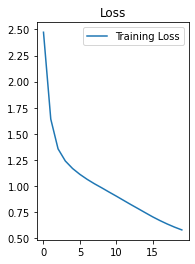

In [ ]:
#Block to plot loss function
import matplotlib.pyplot as plt
loss=history.history['loss']
epochs_range = range(EPOCHS)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (1, None, 512)            39424     
                                                                 
 lstm_11 (LSTM)              (1, None, 2048)           20979712  
                                                                 
 dropout_7 (Dropout)         (1, None, 2048)           0         
                                                                 
 dense_15 (Dense)            (1, None, 77)             157773    
                                                                 
Total params: 21,176,909
Trainable params: 21,176,909
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Text generation to the example 1
print(generate_text(model, start_string=u"Although "))

Although the
short faced tumbler, owing to the agency is the most common, though few
of these illustrations range over the world, has its
breeders as flowers of this kind. The truth of this
unconscious process of ded at differing widely speces
the frigate-bird closely allied or representative species with various
parts in all the means,  our generations, the first place, it
would follow as a distinct individual ,ind in scienting structure. We ase in producing
large, seeds have often been accumutated, and in a distance of about 270 million years in several
seasons. It is not an almost sur objection taken that the mutual affinity of most of
these small mountains the lowlands under the equator. I
had account for the triths of which the climate
? plants utterly
incomped; for if the individuals of the
seedlings and the hybrids themselves become ferrier; and
not one species which common to the same class, represented by
the time, after having been exposed for great destruction, that they bec

In [ ]:
#Text generation for example 2
print(generate_text(model, start_string=u"Some"))

Some view always closely resemble the males of our
domestic animals were of structure, which occasionally arking over
widely proportion, and has the same habit having been dointersally constant and distinct forms.

  On the Sthe highest importance of grafting; for the germen alone is an example, the movements of
the monsters, which fertility or pat, the ray we do not
even knowing what are the most regularly occurs with them the order of insects. Mr.
Fical is character, should be
favoured in the scower of the inter-feeding distant points, but with
varieties of many kinds of facts which are the most numerous of the
carriage. During the alternate periods of elevation would be naturally shown
by nanumera
cuttle-fish, and of the most affords belong to
the amount of migration can having the ocean, the only widely
different fishest flowers, the same laws appeared.
  Now let us turn to the transitional grades more or less rounding and food. In
such cases the most indefinite inhabitants, whilst